## Comparing performance of CBF algorithms - Rank of Top N

In this exercise we will compare 2 different algorithms of collaborative filtering and compare their performances using prediction accuracy evaluation metrics. The algorithms we will compare are - 

 - **User - User** based recommendation
 - **Item - Item** based recommendation
 
The metrics we will use to compare these algorithms are - 

#### Rank based metrics
 
 - **MAP** - mean average precision
 - **MRR** - mean reciprocal rank

The datasets available for this exercise are as follows:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.

In [1]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cs

%matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [2]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [4]:
# Get basic information about the datasets

print movies.shape, ratings.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()

(2500, 3) (264505, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500


### I. Create ground truth for every user

For rank based metics calculation we need to create a relevancy flag for each movie user has already rated. We will then compare this actual relevancy with the recommended ratings and calculate various metrics.

We will define a movie is relevant if its rated above the average rating by the user.

Ratings dataset with relevancy flag applied : 


,userId,movieId,rating,timestamp,rel
0,12882,1,4.0,1147195252,0
1,12882,32,3.5,1147195307,0
2,12882,47,5.0,1147195343,1
3,12882,50,5.0,1147185499,1
4,12882,110,4.5,1147195239,1
5,12882,150,3.5,1147195267,0
6,12882,158,2.0,1147185180,0
7,12882,165,4.0,1147195325,0
8,12882,260,4.0,1147195260,0
9,12882,296,5.0,1147195153,1


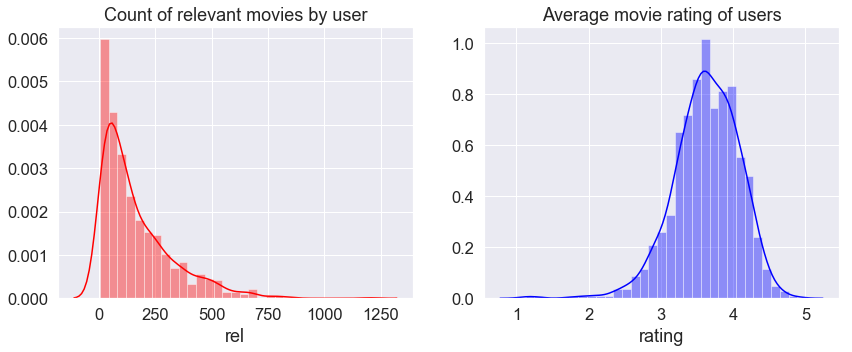

In [5]:
# 1. get the average rating for each user
user_avg = ratings.groupby(by='userId', as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
user_avg = user_avg.rename(columns={'rating':'avg_rating'})

# 2. create a relevancy flag for each rating based on user's average rating
ratings_rel = ratings.merge(user_avg, on='userId', how='inner')
ratings_rel['rel'] = np.where(ratings_rel['rating'] > ratings_rel['avg_rating'],1,0)
ratings_rel = ratings_rel.drop(['avg_rating'], axis=1)

# 3. plot the number of relevant movies for all users
user_avg = ratings_rel.groupby(by='userId', as_index=False).agg({'rating':'mean', 'rel':'sum'}).reset_index(drop=True)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,5))
sns.distplot(user_avg['rel'], color='red', ax=ax1)\
    .set_title("Count of relevant movies by user")
sns.distplot(user_avg['rating'], color='blue', ax=ax2)\
    .set_title("Average movie rating of users")

del user_avg

print "Ratings dataset with relevancy flag applied : "
ratings_rel.head(10)

### II. Divide the ratings data in Test & Train dataset

We will divide the ratings dataset into two groups - train (90%) & test (10%).

The division will be done on user level. So 90% users will be in train and 10% in test. However, we will also keep some rating from test users in training dataset when we want to get their prediction.

#### Test dataset - QUERY vs PROBE

Even from the given test dataset, while trying to get the recommendation for one user we will only keep some movie ratings away from the model (QUERY movies) while we will pass on the remaining movies from that user to the model to be used as history (PROBE movies). 

This division can be done randomly or temporal basis. We will do this based on time (temporal) - keep most recent ratings from a user as query and the older ones as probe. We can do this based on the timestamps available in the ratings dataset.

In [6]:
# 1. Divide ratings dataset into test and train dataset

all_users = ratings_rel['userId'].unique()

np.random.seed(123)
idx = np.random.rand(len(all_users)) < 0.9
train_users = all_users[idx]
test_users = all_users[~idx]

ratings_test = ratings_rel[ratings_rel['userId'].isin(test_users)].reset_index(drop=True)
ratings_train = ratings_rel[ratings_rel['userId'].isin(train_users)].reset_index(drop=True)

print "Number of unique users in RATINGS data : ", all_users.shape[0]
print "Number of unique users in TEST data : ", ratings_test['userId'].nunique()
print "Number of unique users in TRAIN data : ", ratings_train['userId'].nunique()
print ratings.shape, ratings_test.shape, ratings_train.shape

# 2. create QUERY (top 50% most recent ratings from users) and PROBE ratings from test users

ratings_test_n = ratings_test.groupby(by='userId', as_index=False).agg({'movieId':'count'}).reset_index(drop=True)
ratings_test_n['half_n'] = np.round(ratings_test_n['movieId']*0.5)
ratings_test_n = ratings_test_n.drop(['movieId'], axis=1)

ratings_test_query = pd.DataFrame(columns=['userId', 'movieId', 'rating', 'timestamp', 'rel'])

for usr in test_users:
    n = np.int(ratings_test_n[ratings_test_n['userId']==usr].iloc[0,1])
    ratings_test_query_temp = ratings_test[ratings_test['userId']==usr]\
                                .sort_values(by='timestamp', ascending=False).head(n).reset_index(drop=True)
    ratings_test_query = ratings_test_query.append(ratings_test_query_temp)
    del ratings_test_query_temp

del ratings_test_n

ratings_test_query = ratings_test_query.sort_values(by=['userId', 'timestamp'], ascending=[True, False])\
                        .reset_index(drop=True)

ratings_test_probe = ratings_test.merge(ratings_test_query[['userId', 'movieId']], \
                                        on=['userId', 'movieId'], how='outer', indicator=True)
ratings_test_probe = ratings_test_probe[ratings_test_probe['_merge'] == 'left_only']
ratings_test_probe = ratings_test_probe.sort_values(by=['userId', 'timestamp'], ascending=[True, False]).\
                        reset_index(drop=True).drop(['_merge'], axis=1)

# 3. add the PROBE ratings back to the training dataset and keep the QUERY ratings for the test

ratings_train_probe = ratings_train.append(ratings_test_probe)

print "Unique users in Test QUERY dataset : ", ratings_test_query['userId'].nunique()
print "Unique users in Train PROBE dataset : ", ratings_train_probe['userId'].nunique()
print "#Rows in QUERY, PROBE and Train PROBE datasets : "
print ratings_test_query.shape[0]
print ratings_test_probe.shape[0]
print ratings_train_probe.shape[0]

Number of unique users in RATINGS data :  862
Number of unique users in TEST data :  98
Number of unique users in TRAIN data :  764
(264505, 4) (31624, 5) (232881, 5)
Unique users in Test QUERY dataset :  98
Unique users in Train PROBE dataset :  862
#Rows in QUERY, PROBE and Train PROBE datasets : 
15813
15811
248692


In [7]:
ratings_test_query.head()

,userId,movieId,rating,timestamp,rel
0,1015,2410,3.5,1171729506,0
1,1015,2409,4.0,1171729500,1
2,1015,1954,4.0,1171729496,1
3,1015,1350,3.0,1169979961,0
4,1015,8907,3.5,1168879506,0


In [8]:
ratings_test_probe.head()

,userId,movieId,rating,timestamp,rel
0,1015,1,4.0,1105354580,1
1,1015,318,5.0,1105354569,1
2,1015,110,5.0,1105354565,1
3,1015,150,3.5,1105354563,0
4,1015,590,4.0,1105354559,1


In [9]:
ratings_train_probe.head()

,userId,movieId,rating,timestamp,rel
0,12882,1,4.0,1147195252,0
1,12882,32,3.5,1147195307,0
2,12882,47,5.0,1147195343,1
3,12882,50,5.0,1147185499,1
4,12882,110,4.5,1147195239,1


### III. Algorithm 1. User - User collaborative filtering

The complete algorithm for user user based CBF will be done in the following defined function. Steps for this algo - 

1. create adjusted user movie rating
2. create similarity score for each user with every other user
3. create recommendation for the target user based on the similarity scores

In [10]:
##################
# 1. adjust user ratings for each movie

user_ratings_uu = ratings_train_probe.groupby(by='userId', as_index=False).agg({'rating' : 'mean'}).\
                    reset_index(drop=True)
user_ratings_uu = user_ratings_uu.rename(columns={'rating':'avg_rating'})

ratings_adj_uu = ratings_train_probe.merge(user_ratings_uu, on='userId', how='inner')
ratings_adj_uu['rating_adj'] = ratings_adj_uu['rating'] - ratings_adj_uu['avg_rating']

##################
# 2. create a transformed dataset for user and movieid level to get the adjusted ratings & calculate similarity

ratings_adj_tf_uu = ratings_adj_uu[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='userId', columns='movieId', values='rating_adj').fillna(0)
# similarity matrix - cosine distance
dist_uu = pd.DataFrame(data=cs(ratings_adj_tf_uu), index=ratings_adj_tf_uu.index, columns=ratings_adj_tf_uu.index)

##################
# 3. function to score the movies for a given target user

def movie_reco_uu(user, nbr=30, keep_rated=1):
    
    # get the distance for the target user with every other user
    dist_temp = dist_uu[dist_uu.index == user].sort_values(by = user, axis =1, ascending=False)
    dist_temp = dist_temp.iloc[:,0:nbr+1].transpose().reset_index()
    dist_temp = dist_temp.rename(columns={user:'user_similarity'})
    dist_temp['target_user'] = user
    dist_temp = dist_temp[dist_temp['userId'] != user]
    dist_temp['target_avg_rating'] = user_ratings_uu[user_ratings_uu['userId'] == user]['avg_rating'].iloc[0]
    
    # get the movie ratings for all the userid who are the top neighbors
    dist_temp = dist_temp.merge(ratings_adj_uu[['userId', 'movieId', 'avg_rating', 'rating_adj']],\
                                on='userId', how='inner')
    dist_temp = dist_temp.sort_values(by=['movieId', 'userId']).reset_index(drop=True)
    
    # remove movies that don't have more than 2 users
    movie_users = dist_temp.groupby(by='movieId', as_index=False).agg({'userId':'nunique'}).reset_index(drop=True).\
                    rename(columns={'userId':'user_count'})
    dist_temp = dist_temp.merge(movie_users, on='movieId', how='inner')
    dist_temp = dist_temp[dist_temp['user_count'] > 2]
    dist_temp['score'] = dist_temp['rating_adj'] * dist_temp['user_similarity']
    
    # get the score for each movie
    movie_score = dist_temp.groupby(by='movieId', as_index=False).agg({'score':'sum', 'user_similarity':'sum'})
    movie_score['target_avg_rating'] = user_ratings_uu[user_ratings_uu['userId'] == user]['avg_rating'].iloc[0]
    movie_score['final_score'] = movie_score['target_avg_rating'] + \
                                    (movie_score['score']/movie_score['user_similarity'])
    movie_score = movie_score.sort_values(by='final_score', ascending=False).reset_index(drop=True)
    movie_score = movie_score.merge(movies, on='movieId', how='inner')
    
    # remove the movies which the user has already rated
    if keep_rated == 0:
        movie_already_rated = list(ratings_train_probe[ratings_train_probe['userId'] == user][['movieId']].iloc[:,0])
        movie_score = movie_score[~movie_score['movieId'].isin(movie_already_rated)]
        del movie_already_rated
    
    # delete temp datasets
    del dist_temp
    del movie_users
    
    # return the top relevant movies
    return movie_score[['movieId', 'title', 'genres', 'final_score']]

### IV. Algorithm 2 : Item - Item collaborative filtering

The steps for the item - item based CBF will be as follows : 

1. Create adjusted rating for every movie
2. Get similarity scores between every movie
3. rank each movie for a given target user based on a score created using similarity scores between the movie and the top neighbors of the movies (which target user has rated).

In [11]:
#############################
# 1. adjust ratings for each movie user combo
movie_ratings_ii = ratings_train_probe.groupby(by='movieId', as_index=False).agg({'rating' : 'mean'}).\
                    reset_index(drop=True)
movie_ratings_ii = movie_ratings_ii.rename(columns={'rating':'avg_rating'})

ratings_adj_ii = ratings_train_probe.merge(movie_ratings_ii,on='movieId', how='inner')
ratings_adj_ii['rating_adj'] = ratings_adj_ii['rating'] - ratings_adj_ii['avg_rating']

#############################
# 2. create a transformed dataset for user and movieid level to get the adjusted ratings & get similarity scores
ratings_adj_tf_ii = ratings_adj_ii[['userId', 'movieId', 'rating_adj']].\
                    pivot(index='movieId', columns='userId', values='rating_adj').fillna(0)
# similarity matrix - cosine distance
dist_ii = pd.DataFrame(data=cs(ratings_adj_tf_ii), index=ratings_adj_tf_ii.index, columns=ratings_adj_tf_ii.index)

#############################
# 3. user level movie rating averages to be used in the final scoring of the movie

user_rating_ii = ratings_train_probe.groupby(by='userId', as_index=False).agg({'rating':'mean', 'movieId':'count'})\
                .reset_index(drop=True)
user_rating_ii = user_rating_ii.rename(columns={'rating':'avg_user_rating', 'movieId':'rated_movies'})
user_rating_ii = user_rating_ii.sort_values(by='rated_movies', ascending=False).reset_index(drop=True)

#############################
# 4. function to score the movies for a given target user

def movie_reco_ii(user, ngbr=30, keep_rated=1):
    
    #####
    # the seen movies or the rated movies by the user
    movie_already_rated = ratings_adj_ii[ratings_adj_ii['userId'] == user][['movieId', 'rating_adj']]\
                            .reset_index(drop=True)
    N = movie_already_rated.shape[0]
    
    #####
    # the similarity metrics between the seen and unseen movies
    dist_temp = dist_ii.copy()
    dist_temp.reset_index(inplace=True)
    # transform the distance table to long form
    dist_temp = pd.melt(dist_temp, id_vars=['movieId'], value_vars=list(dist_temp.columns)[1:]\
                        , var_name='unseen_movie', value_name='similarity')
    dist_temp = dist_temp.merge(movie_already_rated, on='movieId', how='inner')
    dist_temp = dist_temp.sort_values(by=['unseen_movie', 'similarity'], ascending=[True, False])\
                .reset_index(drop=True)
    # replace the negative similarity with 0
    dist_temp.loc[dist_temp['similarity'] < 0, ['similarity']] = 0
    
    #####
    # Keep top specified neighbors for each unseen movie based on the similarity scores
    if N >= ngbr:
        dist_temp_ngbr = dist_temp.groupby(by='unseen_movie', as_index=False).head(ngbr).reset_index(drop=True)
    else:
        dist_temp_ngbr = dist_temp.groupby(by='unseen_movie', as_index=False).head(N).reset_index(drop=True)
    
    #####
    # calculate the score for each unseen movie
    dist_temp_ngbr['wgt_score'] = dist_temp_ngbr['rating_adj'] * dist_temp_ngbr['similarity']
    movie_scores = dist_temp_ngbr.groupby(by='unseen_movie', as_index=False)\
                    .agg({'wgt_score':'sum', 'similarity':'sum'}).reset_index(drop=True)
    movie_scores['final_score'] = user_rating_ii[user_rating_ii['userId'] == user]['avg_user_rating'].iloc[0] + \
                                (movie_scores['wgt_score']/movie_scores['similarity'])
    movie_scores = movie_scores.sort_values(by='final_score', ascending=False).reset_index(drop=True)
    movie_scores = movie_scores.rename(columns={'unseen_movie':'movieId'})
    
    #####
    # 4. remove the movies already rated by the user
    if keep_rated == 0:
        movie_already_rated = list(ratings_train_probe[ratings_train_probe['userId'] == user][['movieId']].iloc[:,0])
        movie_scores = movie_scores[~movie_scores['movieId'].isin(movie_already_rated)]
        del movie_already_rated
    
    #####
    # 5. get the details of the movies - title, genre
    movie_scores = movie_scores.merge(movies, on='movieId', how='inner')
    
    #####
    # 6. delete temp tables
    del dist_temp
    del dist_temp_ngbr
    
    #####
    # 7. return the scored movie list
    return movie_scores[['movieId', 'title', 'genres', 'final_score']]

### V. Get the recommendations for all the users in test QUERY

We will create two datasets - one for user user recommendations and one for item item recommendations.

In [29]:
st = time.time()

# user user recommendation master dataset

reco_uu = pd.DataFrame(columns=['userId', 'movieId', 'title', 'genres', 'final_score',\
                                'rating', 'rel', 'prec'])

reco_ii = pd.DataFrame(columns=['userId', 'movieId', 'title', 'genres', 'final_score',\
                                'rating', 'rel', 'prec'])

for usr in ratings_test_query['userId'].unique():
    
    # get test user's actual rating and relevancy flag
    usr_rel = ratings_rel[ratings_rel['userId'] == usr][['movieId', 'rel', 'rating']]
 
    # top 20 recommendation from user user algo
    temp = movie_reco_uu(user=usr, nbr=20, keep_rated=1)
    temp = temp.iloc[0:20,:]
    temp = temp.merge(usr_rel, on='movieId', how='left').fillna(0)
    temp['userId'] = usr
    temp['prec'] = 0
    for i in range(temp.shape[0]):
        t1 = temp.iloc[0:i+1,:]
        prec = 1.0*t1['rel'].sum()/(i+1)
        temp.loc[i,['prec']] = prec
        
    # add the reco to master database
    reco_uu = reco_uu.append(temp).reset_index(drop=True)
    del t1
    del temp
    
    # top 20 recommendation from item item algo
    temp = movie_reco_ii(user=usr, ngbr=20, keep_rated=1)
    temp = temp.iloc[0:20,:]
    temp = temp.merge(usr_rel, on='movieId', how='left').fillna(0)
    temp['userId'] = usr
    temp['prec'] = 0
    for i in range(temp.shape[0]):
        t1 = temp.iloc[0:i+1,:]
        prec = 1.0*t1['rel'].sum()/(i+1)
        temp.loc[i,['prec']] = prec
        
    # add the reco to master database
    reco_ii = reco_ii.append(temp).reset_index(drop=True)
    del temp
    del t1
    
et = time.time()

print "Time to finish :", round((et-st)/60,2), "mins"

Time to finish : 4.13 mins


In [32]:
print "Number of users in the user user recommendation dataset :", reco_uu['userId'].nunique()
reco_uu.head()

Number of users in the user user recommendation dataset : 98


,final_score,genres,movieId,prec,rating,rel,title,userId
0,4.775674,Crime|Drama,318,1.000000,5.0,1.0,"Shawshank Redemption, The (1994)",1015
1,4.740653,Drama,5014,1.000000,4.5,1.0,I Am Sam (2001),1015
2,4.708795,Crime|Drama|Mystery,44665,0.666667,0.0,0.0,Lucky Number Slevin (2006),1015
3,4.612174,Action|Adventure|Sci-Fi|IMAX,68358,0.500000,0.0,0.0,Star Trek (2009),1015
4,4.607951,Crime|Horror|Thriller,593,0.400000,0.0,0.0,"Silence of the Lambs, The (1991)",1015


In [33]:
print "Number of users in the item item recommendation dataset :", reco_ii['userId'].nunique()
reco_ii.head()

Number of users in the item item recommendation dataset : 98


,final_score,genres,movieId,prec,rating,rel,title,userId
0,4.580628,Action|Drama|Romance|War,4310,1.000000,5.0,1.0,Pearl Harbor (2001),1015
1,4.472642,Animation|Children|Drama|Musical|Romance,48,0.500000,0.0,0.0,Pocahontas (1995),1015
2,4.448467,Comedy,135,0.666667,4.0,1.0,Down Periscope (1996),1015
3,4.442725,Drama|Romance,1721,0.750000,5.0,1.0,Titanic (1997),1015
4,4.441132,Drama|Mystery|Romance|Thriller,1597,0.800000,5.0,1.0,Conspiracy Theory (1997),1015


### VI. Evaluate the recommendation from both algorithm - MAP@N

Mean average precision @ top N recommendation is calculated as follows - 

 - get the the top N recommendation for the test user
 - for every user calculate the average precision @ top N recommendation (AP@N - formula below)
 - Average AP@N of all test users to get the MAP@N
 
**Formula for Precision for k recommendations (P(k))-**

\begin{equation*}
P(k) =  \frac{\sum_{i}^k rel(i)}{k}
\end{equation*}

where - 
 - $rel(i)$ is a flag of 1 or 0 to indicate if ith recommendation was relevant or not


**Formula for calculating the Average Precision for N recommendations AP@N -** 

\begin{equation*}
AP@N =  \frac{\sum_{k=1}^N P(k) . rel(k)}{m}
\end{equation*}

where -
 - $rel(k)$ is a flag of 1 or 0 to indicate if kth recommendation was relevant or not
 - m is the total number of relevant items for users in total
 - N is the top N recommendation from our algo

**Formula for calculating the MAP@N for U test users-** 

\begin{equation*}
MAP@N =  \frac{\sum_{u=1}^U AP@N}{U} = \frac{\sum_{u=1}^U (\frac{\sum_{k=1}^N P(k)_u . rel(k)_u}{m_u})}{U}
\end{equation*}


where - 
 - U is the total number of test users
 
**We will use top 20 recommendations (N=20) from our algo and neighbourhood size of 20.**

In [40]:
# 1. MAP for user user recommendation

reco_uu['avg_prec'] = reco_uu['prec']*reco_uu['rel']
reco_uu_final = reco_uu.groupby(by='userId', as_index=False).agg({'avg_prec':'sum', 'movieId':'count'})\
                    .reset_index(drop=True)

# for average precision calculation we will use the value of m as N. This is because in reality the actual number
# of relevant movies for every user is very high compared to N=20 and also varies a lot from user to user
reco_uu_final['ap'] = reco_uu_final['avg_prec']/reco_uu_final['movieId']

reco_uu_map = reco_uu_final['ap'].mean()

print "MAP@20 for user user algo :", reco_uu_map
del reco_uu_final

# 2. MAP for item item recommendation

reco_ii['avg_prec'] = reco_ii['prec']*reco_ii['rel']
reco_ii_final = reco_ii.groupby(by='userId', as_index=False).agg({'avg_prec':'sum', 'movieId':'count'})\
                    .reset_index(drop=True)

# for average precision calculation we will use the value of m as N. This is because in reality the actual number
# of relevant movies for every user is very high compared to N=20 and also varies a lot from user to user
reco_ii_final['ap'] = reco_ii_final['avg_prec']/reco_ii_final['movieId']

reco_ii_map = reco_ii_final['ap'].mean()
print "MAP@20 for item item algo :", reco_ii_map
del reco_ii_final

MAP@20 for user user algo : 0.188608981732
MAP@20 for item item algo : 0.384027341653


### VII. Evaluate the recommendation from both algorithm - MRR

The formula for mean reciprocal rank is as follows - 

\begin{equation*}
MRR = \frac{\sum_{u=1}^U \frac{1}{k_u}}{U}
\end{equation*}

So, its the average of all individual test user's (U) reciprocal rank. 

Reciprocal rank for an user is the reciprocal value of the rank of first relevant item ($k_u$) in the top N recommendation.

In [71]:
# 1. MRR for user user algo

reco_uu_mrr = pd.DataFrame(columns=['userId', 'rec_rank'])

for usr in reco_uu['userId'].unique():
    temp = reco_uu[reco_uu['userId'] == usr].reset_index(drop=True)
    for i in range(temp.shape[0]):
        if temp.loc[i,['rel']][0] == 1:
            rec_rank = 1.0/(i+1)
            break
    temp_mrr = pd.DataFrame(columns=['userId', 'rec_rank'])
    temp_mrr.loc[0,['userId']] = usr
    temp_mrr.loc[0,['rec_rank']] = rec_rank
    
    reco_uu_mrr = reco_uu_mrr.append(temp_mrr)
    del temp
    del temp_mrr
    
reco_uu_mrr_final = np.round(reco_uu_mrr['rec_rank'].mean(),3)
del reco_uu_mrr

print "Mean reciprocal rank for User - User algo :", reco_uu_mrr_final

# 2. MRR for item item algo

reco_ii_mrr = pd.DataFrame(columns=['userId', 'rec_rank'])

for usr in reco_ii['userId'].unique():
    temp = reco_ii[reco_ii['userId'] == usr].reset_index(drop=True)
    for i in range(temp.shape[0]):
        if temp.loc[i,['rel']][0] == 1:
            rec_rank = 1.0/(i+1)
            break
    temp_mrr = pd.DataFrame(columns=['userId', 'rec_rank'])
    temp_mrr.loc[0,['userId']] = usr
    temp_mrr.loc[0,['rec_rank']] = rec_rank
    
    reco_ii_mrr = reco_ii_mrr.append(temp_mrr)
    del temp
    del temp_mrr
    
reco_ii_mrr_final = np.round(reco_ii_mrr['rec_rank'].mean(),3)
del reco_ii_mrr

print "Mean reciprocal rank for Item - Item algo :", reco_ii_mrr_final

Mean reciprocal rank for User - User algo : 0.514
Mean reciprocal rank for Item - Item algo : 0.867


### Result

Based on the MAP and MRR scores, item item algo provides higher precision in the top 20 recommendation.